# Lab 1 - Training a Machine Learning Model

The goal of this lab is to demonstarte how to orchestrate machine learning **training** with Azure Machine Learning service. 

To keep the focus of the lab on **workflow orchestration** rather then on idiosyncrasies of a domain problem, we have chosen a relatively simple machine learning scenario.


## Scenario

You will train a binary classification model to predict propensity to purchase. The dataset comes from the UCI Machine Learning repository, and it is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The goal of the model is to help with campaign planning by predicting which clients will respond positively to marketing phone calls. 


## Connect AML workspace

Check the version of AML SDK.

In [1]:
# Verify AML SDK Installed

import azureml.core
print("SDK Version:", azureml.core.VERSION)

SDK Version: 1.0.2


Connect to the workspace.

In [2]:
from azureml.core import Workspace

# Connect to workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

Found the config file in: /data/home/demouser/notebooks/AMLsWorkshop/aml_config/config.json
jkamlworkshop
jkamlworkshop
southcentralus
952a710c-8d9c-40c1-9fec-f752138cc0b3


## Prepare training data
### Download the dataset
The dataset can be downloaded from a public Azure Blob Storage container.


In [3]:
import os

folder = '../datasets'
filename = 'banking.csv'
os.makedirs(folder, exist_ok=True)
downloadCommand = 'wget -O ''{0}/{1}'' ''https://azureailabs.blob.core.windows.net/banking/{1}'''.format(folder, filename)
print(downloadCommand)
os.system(downloadCommand)
os.listdir(folder)

wget -O ../datasets/banking.csv https://azureailabs.blob.core.windows.net/banking/banking.csv


['banking.csv']

### Explore the dataset


In [4]:
import numpy as np
import pandas as pd
import os

folder = '../datasets'
filename = 'banking.csv'
pathname = os.path.join(folder, filename)
df = pd.read_csv(pathname, delimiter=',')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp_var_rate      41188 non-null float64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
y                 41188 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usag

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


The dataset combines the information about the bank's customers with the results of previous campaigns and key economic indicators. It includes 41,188 records and 21 fields. The columns are a mix of numeric and categorical data types.

The `y` column indicates whether the customer subscribed to a term deposit. This is our `target` variable or `label`. The goal of the model is to predict this column on new examples.

Some information that exists in the historical dataset will not be available when planning a new campaign. 

Please refer to [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing) for more information. 

We will use the following features for training. 

In [5]:
feature_columns = [
                   # Demographic
                   'age', 
                   'job', 
                   'education', 
                   'marital', 
                   'default', 
                   'housing', 
                   'loan', 
                   # Previous campaigns
                   'month',
                   'campaign',
                   'poutcome',
                   # Economic indicators
                   'emp_var_rate',
                   'cons_price_idx',
                   'cons_conf_idx',
                   'euribor3m',
                   'nr_employed']

Before further analysis, let's reserve a portion of data for testing.

In [6]:
from sklearn.model_selection import train_test_split

train_raw, test_raw = train_test_split(
   df[feature_columns + ['y']], 
   test_size = 0.2,
   stratify = df['y'])

Let's now look at the class distribution in training data.

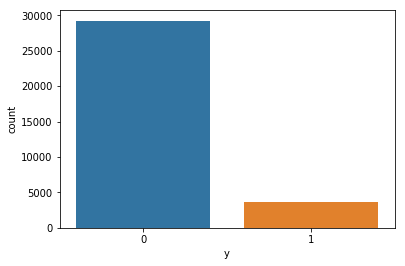

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(train_raw.y)

The training dataset is very imbalanced. We will need to address this when configuring training.

## Train the model

In this section of the lab you will train a binary classification model.

You will first run training on a local compute and use Azure Machine Learning Experiment to track training progress. In the following step, you will use Azure Machine Learning Compute to run  training job on more powerful cloud compute resources.


### Prepare training pipeline

#### Configure feature transformations

All `scikit-learn` estimators expect continuous input. Some of the features in the dataset are categorical and encoded as `strings`. We will use *one-hot* encoding to convert categorical features to numeric values. Since we are going to use *LogisticRegression*, we also need to scale numeric features.

In [8]:

# One hot encode all categorical features 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ohenc = OneHotEncoder(sparse=False)
scaler = StandardScaler()

categorical_columns = train_raw.select_dtypes(include=[object]).columns
numeric_columns = train_raw.drop(columns=categorical_columns.tolist()+['y']).columns

ct = ColumnTransformer(
    [('onehot', ohenc, categorical_columns),
     ('scaler', scaler, numeric_columns)],
     remainder='passthrough'
     )

#### Configure training pipeline

*LogisticRegression* exposes a number of tuneable hyperparameters. Argueable, the most important setting is the inverse of regularization strength **C** . For the sake of simplicity, we will focus on tuning this hyperparameter when training our model. We will use *GridSearchCV* to automate the hyperparameter tuning process.

Since the dataset is imbalanced we will set *class_weight* parameter to `balanced` to automatically adjust weights inversely proportional to class frequencies in in the input data.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Create logistic regression
lr = LogisticRegression(solver='lbfgs', max_iter=300, class_weight='balanced')

pipeline = make_pipeline(ct, lr)

pipeline.fit(train_raw[feature_columns], train_raw.y)






/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehot', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
    ...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [10]:
y_pred = pipeline.predict(test_raw)

/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [11]:
pipeline.score(test_raw, test_raw.y)

/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


0.8259286234522942

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create logistic regression
lr = LogisticRegression(solver='lbfgs', max_iter=300, class_weight='balanced')

# Set up parameter grid for C
param_grid = {'C': [0.5, 1, 2]}

# Configure grid search
clf = GridSearchCV(lr, param_grid, 
                   cv=5, 
                   scoring='accuracy',
                   return_train_score = False
                   )

# Start training
X = ct.fit_transform(train_raw.drop(columns='y'))
y = train_raw.y

clf.fit(X, y)



/anaconda3/envs/aml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/aml/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=300,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.5, 1, 2]}, pre_dispatch='2*n_jobs', refit=True,
       return_train_score=False, scoring='accuracy', verbose=0)

In [53]:
for C, score in zip(clf.cv_results_['params'], clf.cv_results_['mean_test_score']):
    print("C: {}, score: {}".format(C, score))

C: {'C': 0.5}, score: 0.8300151745068285
C: {'C': 1}, score: 0.8301365705614567
C: {'C': 2}, score: 0.8301365705614567


### Run training on a local compute


In [38]:
# Configure RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


lr = LogisticRegression(solver='lbfgs', max_iter=300, class_weight='balanced')

X = ct.fit_transform(train_raw.drop(columns='y'))
y = train_raw.y

scores = cross_val_score(
    lr, X, y, cv=5, scoring="recall")
scores


/anaconda3/envs/aml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/aml/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([0.62987887, 0.63526245, 0.62668464, 0.65768194, 0.61051213])

## Use Azure Machine Learning to log performance metrics
In the steps that follow, you will train multiple models using different values of C and observe the impact on performance (accuracy). Each time you create a new model, you are executing a Run in the terminology of Azure Machine Learning service. In this case, you will create one Experiment and execute multiple Runs within it, each with different value of C.

Execute the following cell to quickly verify you have the Azure Machine Learning SDK installed on your cluster. If you get a version number back without error, you are ready to proceed.

To begin capturing metrics, you must first create an Experiment and then call `start_logging()` on that Experiment. The return value of this call is a Run. This root run can have other child runs. When you are finished with an experiment run, use `complete()` to close out the root run. Execute the following cell to train four different models using differing amounts of training data and log the results to Azure Machine Learning.

In [ ]:
# Create an experiment and log metrics for multiple training runs

from azureml.core.run import Run
from azureml.core.experiment import Experiment

# start a training run by defining an experiment
myexperiment = Experiment(ws, "usedcars_training_local")
root_run = myexperiment.start_logging()

training_set_percentage = 0.25
C = 2
run = root_run.child_run("Training_Set_Percentage-%0.5F" % training_set_percentage)
model, score = train_eval_model(full_X, full_Y, training_set_percentage, C)
print("With C={}, model accuracy reached {}".format(C, score))
run.log("Training_Set_Percentage", training_set_percentage)
run.log("C", C)
run.log("Accuracy", score)
run.complete()

C = 1
run = root_run.child_run("Training_Set_Percentage-%0.5F" % training_set_percentage)
model, score = train_eval_model(full_X, full_Y, training_set_percentage, C)
print("With C={}, model accuracy reached {}".format(C, score))
run.log("Training_Set_Percentage", training_set_percentage)
run.log("C", C)
run.log("Accuracy", score)
run.complete()

C = 0.75
run = root_run.child_run("Training_Set_Percentage-%0.5F" % training_set_percentage)
model, score = train_eval_model(full_X, full_Y, training_set_percentage, C)
print("With C={}, model accuracy reached {})".format(C, score))
run.log("Training_Set_Percentage", training_set_percentage)
run.log("C", C)
run.log("Accuracy", score)
run.complete()

C = 0.5
run = root_run.child_run("Training_Set_Percentage-%0.5F" % training_set_percentage)
model, score = train_eval_model(full_X, full_Y, training_set_percentage, C)
print("With C={}, model accuracy reached {})".format(C, score))
run.log("Training_Set_Percentage", training_set_percentage)
run.log("C", C)
run.log("Accuracy", score)
run.complete()

# Close out the experiment
root_run.complete()

Now that you have captured history for various runs, you can review the runs. You could use the Azure Portal for this - go to the Azure Portal, find your Azure Machine Learning Workspace, select Experiments and select the UsedCars_Experiment. However, in this case we will use the AML SDK to query for the runs. Execute the following cell to view the runs and their status.

In [ ]:
# Review captured runs
# Go to the Azure Portal, find your Azure Machine Learning Workspace, select Experiments and select the UsedCars_Experiment

# You can also query the run history using the SDK.
# The following command lists all of the runs for the experiment
runs = [r for r in root_run.get_children()]
print(runs)

## Train remotely using Azure ML Compute

Up until now, all of your training was executed locally on the same machine running Jupyter. Now you will execute the same logic targeting a remote Azure ML Compute, which you will provision from code.

In [ ]:
# Connect to workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

In [ ]:
# Create an Azure ML Compute cluster

# Create Azure ML cluster
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
cluster_name = "cpu-bai-cluster"
cluster_min_nodes = 1
cluster_max_nodes = 3
vm_size = "STANDARD_DS11_V2"

if cluster_name in ws.compute_targets:
    compute_target = ws.compute_targets[cluster_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('Found existing compute target, using this compute target instead of creating:  ' + cluster_name)
    else:
        print("Error: A compute target with name ",cluster_name," was found, but it is not of type AmlCompute.")
else:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size, 
                                                                min_nodes = cluster_min_nodes, 
                                                                max_nodes = cluster_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current BatchAI cluster status, use the 'status' property    
    print(compute_target.status.serialize())

With your cluster ready, you need to upload the training data to the default DataStore for your AML Workspace (which uses Azure Storage). 

In [ ]:
# Upload the dataset to the DataStore

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
ds.upload(src_dir='../datasets', target_path='used_cars', overwrite=True, show_progress=True)

Next, you will need to create a training script that is similar to the code you have executed locally to train the model. 

In [ ]:
import os
script_folder = './script'
os.makedirs(script_folder, exist_ok=True)

In [ ]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import pandas as pd

from sklearn import linear_model 
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from azureml.core import Run

# let user feed in 2 parameters, the location of the data files (from datastore), and the training set percentage to use
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--training-set-percentage', type=float, dest='training_set_percentage', default=0.25, help='percentage of dataset to use for training')
parser.add_argument('--C', type=float, dest='C', default=1, help='regularization')
args = parser.parse_args()

data_folder = os.path.join(args.data_folder, 'used_cars')
print('Data folder:', data_folder)
data_csv_path = os.path.join(data_folder, 'UsedCars_Clean.csv')
print('Path to CSV file dataset:' + data_csv_path)

# Load the data
#df = pd.read_csv('UsedCars_Clean.csv', delimiter=',')
df = pd.read_csv(data_csv_path)
df['Affordable'] = np.where(df['Price']<12000, 1, 0)
df_affordability = df[["Age","KM", "Affordable"]]


# Now experiment with different training subsets
from sklearn.model_selection import train_test_split
full_X = df_affordability[["Age", "KM"]]
full_Y = df_affordability[["Affordable"]]

def train_eval_model(full_X, full_Y,training_set_percentage, C):
    train_X, test_X, train_Y, test_Y = train_test_split(full_X, full_Y, train_size=training_set_percentage, random_state=42)
    
    # Flatten labels
    train_Y = np.ravel(train_Y)
    test_Y = np.ravel(test_Y)
    
    # Convert to float
    train_X = train_X.astype(float)
    test_X = test_X.astype(float)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(train_X)
    clf = linear_model.LogisticRegression(C=C, solver='lbfgs')
    clf.fit(X_scaled, train_Y)

    scaled_inputs = scaler.transform(test_X)
    predictions = clf.predict(scaled_inputs)
    score = accuracy_score(test_Y, predictions)

    return (clf, score)

# Acquire the current run
run = Run.get_context()


training_set_percentage = args.training_set_percentage
C = args.C
model, score = train_eval_model(full_X, full_Y, training_set_percentage, C)
print("With C={}, model accuracy reached {})".format(C, score))
run.log("Training_Set_Percentage", training_set_percentage)
run.log("C", C)
run.log("Accuracy", score)


# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/model.pkl')


Create an estimator that descrives the configuration of the job that will execute your model training script.

In [ ]:
# Create estimator
#############################
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.as_mount(),
    '--training-set-percentage': 0.3,
    '--C': 2
}

est_config = Estimator(source_directory=script_folder,
                       script_params=script_params,
                       compute_target=compute_target,
                       entry_script='train.py',
                       conda_packages=['scikit-learn', 'pandas'])

Submit the job using the submit() method of the Experiment object. 

In [ ]:
#  Execute the estimator job
#####################################

# Create new experiment
from azureml.core import Experiment
experiment_name = "usedcars_training_amlcompute"
exp = Experiment(workspace=ws, name=experiment_name)

run = exp.submit(config=est_config)
run


You can monitor the job through Azure Portal or using AML Jupyter Widget.

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()


In [ ]:
# Poll for job status
run.wait_for_completion(show_output=True)  # value of True will display a verbose, streaming log

# Examine the recorded metrics from the run
print(run.get_metrics())